# DEPENDENCIES FOR DATA GENERATION
> **Source of the synthetic regression tasks**: [_Benchmarking Bayesian Neural Networks and Evaluation Metrics for Regression Tasks_ by Brian Staber and Sebastien Da Veiga](https://arxiv.org/pdf/2206.06779) (check appendix B in this paper)

# Necessary Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

# Function to Generate Synthetic Regression Problems
Regression will be done on this synthetic data. We generate the data using:

$y_i = f(x_i) + \epsilon_i$

- $y_i$ is the dependent variable (the "output" or "target")
- $x_i$ is the tuple of independent variables (the "inputs" or "features" or "predictors")
- $\epsilon_i$ is the random noise given to the $i$-th data point

The goal of regression is to estimate $f$ given the dataset $D = (x, y) = \{(x_1, y_1), (x_2, y_2) ... (x_n, y_n)\}$.

In [2]:
# SAMPLING INPUTS (FEATURE VALUES)

def sample_synthetic_feature_values(sample_space, sample_size, f, ɛ):
    '''
    ARGUMENTS:
    - `sample_space` is either a pair or a list of pairs; each pair represents a closed interval
    - `sample_size` is the number of input values to be sampled, or a list of the numbers (see NOTE 2 below)
    - `f` is the true regression function, i.e. y = f(x) + ɛ
    - `ɛ` is the noise function used to obtain the synthetic output values

    NOTE 1: The sample space is the union of all the intervals listed in `sample_space`.
    NOTE 2: If `sample_size` is given as a list, then we are supposed to pick from each interval as listed
    '''

    # CASE 1: The sample is a single interval (i.e. the first element is not a pair but a number)
    try:
        float(sample_space[0]) # If no exception occurs, it means the first element is a number
        
        '''
        To sample x from the interval defined by `sample_space`:
        - Take a random sampler from the interval [0, 1] (i.e. `torch.rand`)
        - Scale the sampler by `sample_space[1] - sample_space[0]` (interval size)
        - Shift the scaled sampler by `sample_space[0]` (interval lower bound)
        '''
        x = (sample_space[1] - sample_space[0])*torch.rand(sample_size) + sample_space[0]
    # CASE 2: The sample space is a union of intervals
    except:
        '''
        To sample x from the interval defined by `sample_space`:
        - If `sample_size` is a list, sample each interval as per the numbers listed
        - Else, sample each interval proportional to its size with respect to other intervals
        - Each interval must be sampled in the way described in the `try` block

        NOTE: This is practically the same as uniformly sampling from the union of the intervals in `sample_space`.
        '''
        # Obtaining the list of sample sizes of each interval (if `sample_size` is not a list:
        # If `sample_size` is given as a list:
        if isinstance(sample_size, list):
            sizes = sample_size
        # If `sample_size` is not given as a list but just a number:
        else:
            P, N = [], 0
            for interval in sample_space:
                P.append(interval[1] - interval[0])
                N += interval[1] - interval[0]
            P = np.array(P)/N
            sizes = sample_size*P

        # Drawing the samples:
        x = torch.tensor([])
        for i in range(len(sizes)):
            interval = sample_space[i]
            sample = (interval[1] - interval[0])*torch.rand(int(sizes[i])) + interval[0]
            x = torch.concat([x, sample], axis=0)

        while len(x) < sum(sizes):
            interval = sample_space[int(np.random.choice(a=len(sample_space), p=P))]
            sample = (interval[1] - interval[0])*torch.rand(1) + interval[0]
            x = torch.concat([x, sample], axis=0)
            
    # Returning sampled input values
    return torch.unsqueeze(x, dim=1)
    # Why use `torch.unsqueeze`? Check the implementation notes below this code block.

#================================================
# GENERATING OUTPUTS (TARGET VALUES)

def generate_synthetic_target_values(x, sample_size, f, ɛ):
    if isinstance(sample_size, list):
        y = f(x) + torch.reshape(ɛ(sum(sample_size)), x.shape)
    else:
        y = f(x) + torch.reshape(ɛ(sample_size), x.shape)
    # Why use `torch.reshape`? Check the implementation notes below this code block.
    return y

#================================================
# GENERATING SYNTHETIC DATA

def generate_synthetic_data(sample_space, sample_size, f, ɛ):
    x = sample_synthetic_feature_values(sample_space, sample_size, f, ɛ)
    y = generate_synthetic_target_values(x, sample_size, f, ɛ)
    return x, y

**IMPLEMENTATION NOTE: Use of** `torch.unsqueeze`:

To begin with, all the regression problems except problem D did not need to return `torch.unsqueeze(x, dim=1)`; returning `x` along was sufficient. However, it was not sufficient for problem D because the regression function for problem D is a neural network that needs an input that is either a single input or a tensor of inputs with two dimensions (representing a sequence of inputs), where one of the dimensions is size 1. `torch.unsqueeze` converts `x` from a 1D tensor to a 2D tensor, either a column vector (using the optional argument `dim=1`) or a row vector (using the optional argument `dim=0`). For problem D, I need a column vector because the input shape of the neural network used is 1, which means each input in a sequence of inputs must be such that each row only has one value (thus, a column vector). Of course, this solution retains the functionality of the data generating functions for every other problem too.

**IMPLEMENTATION NOTE: Need to reshape** `ɛ` **according to** `x`:

By default, the noise function produces a 1D tensor. Now, note that for most problems, we do not have to convert `x` to a 2D tensor. In fact, the synthetic output generation for all the regression problems except problem D (before I worked with `x` as a 2D tensor) was as follows:

```python
if isinstance(sample_size, list):
        y = f(x) + ɛ(sum(sample_size))
    else:
        y = f(x) + ɛ(sample_size)
    return y
```

However, since I am working with `x` as a 2D tensor, I need to make sure the vector of noise values matches in shape. Now. it I convert `x` to a row vector using `torch.unsqueeze(x, dim=0)`, there is no need for reshaping, since the vector of noise values matches the shape of a row vector. However, since I am working with `x` as a column vector (for reasons mentioned in the previous implementation note), I need to reshape the vector of noise values accordingly. Of course, I could have used `torch.unsqueeze` for this, but `torch.reshape` is more conceptually convenient.

# Helper Functions

In [3]:
def plot_synthetic_regression_problem(x_train, y_train, x_test, y_test, problem_id):
    figure, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
    
    try: # If the data is in the form of tensors:
        axs[0].scatter(x_train.data.numpy(), y_train.data.numpy(), s=2)
        axs[1].scatter(x_test.data.numpy(), y_test.data.numpy(), s=2)
    except: # If the data is in the form of NumPy arrays:
        axs[0].scatter(x_train, y_train, s=2)
        axs[1].scatter(x_test, y_test, s=2)
    axs[0].set_title('Training Data'), axs[1].set_title('Test Data')
    axs[0].set_xlabel('x'), axs[1].set_xlabel('x')
    axs[0].set_ylabel('y'), axs[1].set_ylabel('y')
    plt.suptitle('Synthetic Regression Data, Problem ' + str(problem_id))
    plt.show()

# Function to return the desired problem's data:
def pick_problem(problem_id):
    return {'A': Problem_A(), 'B': Problem_B(), 'C': Problem_C(), 'D': Problem_D(), 'E': Problem_E()}[problem_id]

# Function to generate data (defined to enable code reusability):
def generate_data(problem_id, visualise_problem=True):
    # Generating the given number of data points:
    data = pick_problem(problem_id)
    
    # Visualising the synthetic regression problem:
    if visualise_problem:
        data.plot_data()
    
    # Obtaining the training and testing data:
    x_train = data.x_train.detach().numpy()
    y_train = data.y_train.detach().numpy()
    x_test = data.x_test.detach().numpy()
    y_test = data.y_test.detach().numpy()
    '''
    NOTE: `.detach().numpy()` is used in case the tensor requires grad (in which case `numpy` cannot be applied).
    `.detach()` creates a copy of the tensor with respect to its values, but this copy never requires grad.
    '''

    return x_train, y_train, x_test, y_test

# Creating and Presenting Synthetic Regression Problems

## Problem A

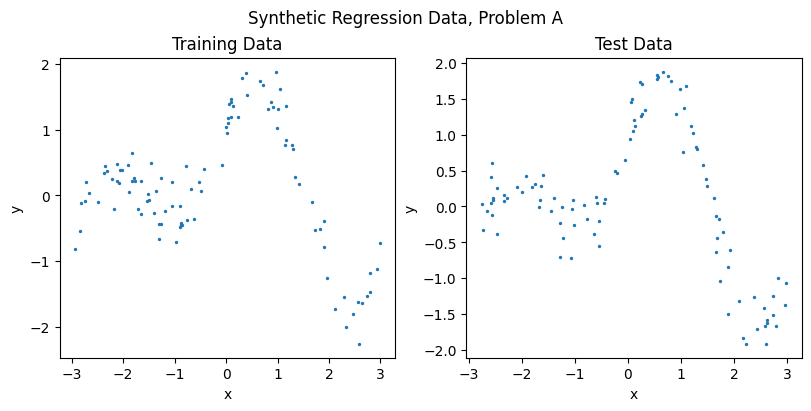

In [4]:
class Problem_A:
    def __init__(self, num_data_points=100):
        self.num_data_points = num_data_points
        self.f = lambda x: np.sin(2*x) + np.cos(x)
        self.ɛ = lambda n: 0.25*torch.randn(n) # Standard deviation = 0.25
        self.x_train, self.y_train = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)
    
    def regenerate_data(self, num_data_points):
        self.num_data_points = num_data_points
        self.x_train, self.y_train = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)

    def plot_data(self):
        plot_synthetic_regression_problem(self.x_train, self.y_train, self.x_test, self.y_test, 'A')

if __name__ == '__main__':
    A = Problem_A()
    A.plot_data()

## Problem B

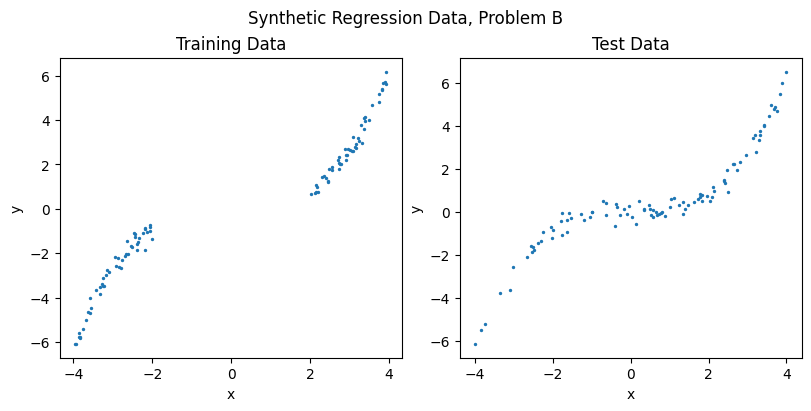

In [6]:
class Problem_B:
    def __init__(self, num_data_points=100):
        self.num_data_points = num_data_points
        self.f = lambda x: 0.1*x**3
        self.ɛ = lambda n: 0.25*torch.randn(n) # Standard deviation = 0.25
        self.x_train, self.y_train = generate_synthetic_data([[-4, -1], [1, 4]], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-4, 4], num_data_points, self.f, self.ɛ)

    def regenerate_data(self, num_data_points):
        self.num_data_points = num_data_points
        self.x_train, self.y_train = generate_synthetic_data([[-4, -2], [2, 4]], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-4, 4], num_data_points, self.f, self.ɛ)

    def plot_data(self):
        plot_synthetic_regression_problem(self.x_train, self.y_train, self.x_test, self.y_test, 'B')

if __name__ == '__main__':
    B = Problem_B()
    B.plot_data()

## Problem C

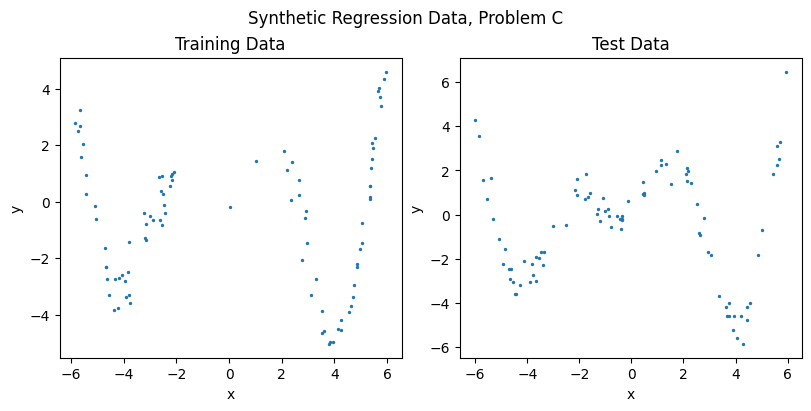

In [8]:
class Problem_C:
    def __init__(self, num_data_points=[49, 49, 2]):
        self.num_data_points = num_data_points
        self.f = lambda x: (1 + x)*np.sin(1.2*x)
        self.ɛ = lambda n: 0.5*torch.randn(n) # Standard deviation = 0.5
        self.x_train, self.y_train = generate_synthetic_data([[-6, -2], [2, 6], [-2, 2]], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-6, 6], sum(num_data_points), self.f, self.ɛ)

    def regenerate_data(self, num_data_points):
        self.num_data_points = num_data_points
        self.x, self.y = generate_synthetic_data([[-6, -2], [2, 6], [-2, 2]], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-6, 6], sum(num_data_points), self.f, self.ɛ)

    def plot_data(self):
        plot_synthetic_regression_problem(self.x_train, self.y_train, self.x_test, self.y_test, 'C')

if __name__ == '__main__':
    C = Problem_C()
    C.plot_data()

## Problem D

In [198]:
class NN(nn.Module):
    def __init__(self):
        torch.manual_seed(3)
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 1, bias=True))

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.normal_(layer.weight)
    
    def forward(self, x):
        return self.model(x)

Total trainable parameters: 20501


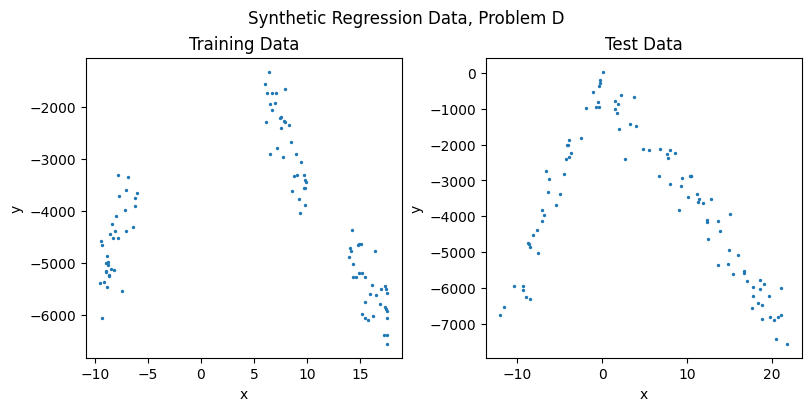

In [204]:
class Problem_D:
    def __init__(self, num_data_points=100):
        # Initialising model:
        model = NN()
            
        # Initialising weights:
        model.apply(model.init_weights)
        # NOTE 1: This model shall be our regression function
        # NOTE 2: `.apply` is explained in the implementation note below
        
        #------------------------------------
        
        self.num_data_points = num_data_points
        self.f = model
        self.ɛ = lambda n: 500*torch.randn(n) # Standard deviation = 500
        self.x_train, self.y_train = generate_synthetic_data([[-10, -6], [6, 10], [14, 18]], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-12, 22], num_data_points, self.f, self.ɛ)
    
    def regenerate_data(self, num_data_points):
        self.num_data_points = num_data_points
        self.x_train, self.y_train = generate_synthetic_data([[-10, -6], [6, 10], [14, 18]], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-12, 22], num_data_points, self.f, self.ɛ)

    def plot_data(self):
        plot_synthetic_regression_problem(self.x_train, self.y_train, self.x_test, self.y_test, 'D')

if __name__ == '__main__':
    D = Problem_D()
    print('Total trainable parameters:', sum(p.numel() for p in D.f.parameters() if p.requires_grad))
    # REFERENCE: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
    D.plot_data()

**NOTE**: _The noise is in fact added, it is just too small to notice; if you increase the standard deviation of ɛ to a large number (e.g. 1000), you can see that the noise is indeed added._

---

**IMPLEMENTATION NOTE: `torch.nn.Module.apply(fn)`**:

Applies `fn` recursively to every submodule (as returned by `.children()`) as well as self. Typical use includes initialising the parameters of a model (for more on initialising module parameters, see:[`nn-init-doc`](https://pytorch.org/docs/stable/nn.init.html)).

> **Reference**: [Source code for `torch.nn.modules.module` (PyTorch documentation)](https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.apply)

# Problem E

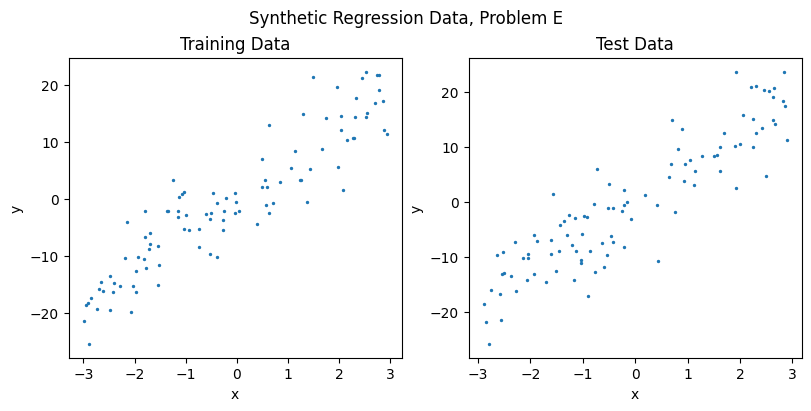

In [201]:
class Problem_E:
    def __init__(self, num_data_points=100):
        self.num_data_points = num_data_points
        self.f = lambda x: 6*x
        self.ɛ = lambda n: 5*torch.randn(n) # Standard deviation = 0.2
        self.x_train, self.y_train = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)
    
    def regenerate_data(self, num_data_points):
        self.num_data_points = num_data_points
        self.x_train, self.y_train = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)
        self.x_test, self.y_test = generate_synthetic_data([-3, 3], num_data_points, self.f, self.ɛ)

    def plot_data(self):
        plot_synthetic_regression_problem(self.x_train, self.y_train, self.x_test, self.y_test, 'E')

if __name__ == '__main__':
    E = Problem_E()
    E.plot_data()